In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd
from decimal import Decimal
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy import stats
import landau
from scipy.interpolate import CubicSpline

In [2]:
savedir = "/icarus/app/users/gputnam/calib/plots/"
dosave=False

In [3]:
branches = [
    "meta.run",
    "meta.evt",
    "meta.iproc",
    "t0",
    "id",
    "clear_cosmic_muon",
    "start_x",
    "start_y",
    "start_z",
    "end_x",
    "end_y",
    "end_z",
    "dir_x",
    "dir_y",
    "dir_z",
    "hit_min_time_p2_tpcE",
    "hit_max_time_p2_tpcE",
    "hit_min_time_p2_tpcW",
    "hit_max_time_p2_tpcW"
]

In [4]:
# fname = "icarus.root"
fname = "/icarus/app/users/gputnam/sbncode/proc/caloanaout_run5458_N1000_procF_stop.root"
folderE = "caloanaCryoE"
folderW = "caloanaCryoW"
tname = "GCalorimetryAnalyzer"

treeE = uproot.open(fname)[folderE][tname]
data = treeE.arrays(branches, library="pd")

In [5]:
# EXTERNAL INPUT: The drift window in TPC E and TPC W
tcathode_E = 3203.15
tcathode_W = 3212.96

# EXTERNAL INPUT: electron lifetime in TPC E and TPC W
electron_lifetime_tpcE = 3.38e3
electron_lifetime_tpcW = 3.65e3

# EXTERNAL INPUT: calibration constant
calibration = 86.00
MEAN_PITCH = 0.3487

In [6]:
# CONFIG

a2c_dist = 148.275 # cm
tanode = 850 # ticks
tick_period = 400 # ns
NTICKS = 4096 # ticks

In [7]:
# Compute predicted R.R. v. dE/dx
mass_electron = 0.5109989461 # MeV https://pdg.lbl.gov/2020/listings/rpp2020-list-K-plus-minus.pdf
mass = 105.6583745 # MeV https://pdg.lbl.gov/2020/listings/rpp2020-list-muon.pdf
Ival = 188.0e-6
Zval = 18.0
Aval = 39.948
Kfactor = 0.307075
LAr_density_gmL = 1.3973

def Calc_MPV_DEDX(pitch, T):
    gamma = (mass+T)/mass
    beta = pow(1.0-pow(gamma,-2.0),0.5)
    Wmax = (2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0))/(1.0+2.0*gamma*(mass_electron/mass)+pow(mass_electron/mass,2.0))

    # Medium energy 
    dens_factor = 2.0*np.log(10)*np.log10(beta*gamma)-5.2146+0.19559*pow(3.0-np.log10(beta*gamma),3.0)
    # low energy
    dens_factor[np.log10(beta*gamma) < 0.2] = 0.
    # high energy
    dens_factor[np.log10(beta*gamma) > 3.0] = (2.0*np.log(10)*np.log10(beta*gamma)-5.2146)[np.log10(beta*gamma) > 3.0]
    dEdx_mean = LAr_density_gmL*Kfactor*(Zval/Aval)*pow(beta,-2.0)*(0.5*np.log(2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0)*Wmax*pow(Ival,-2.0))-pow(beta,2.0)-dens_factor/2.0)
    xi = (Kfactor/2.0)*(Zval/Aval)*pow(beta,-2.0)*LAr_density_gmL*pitch
    kappa = xi/Wmax
    dEdx_MPV = xi*(np.log((2.0*mass_electron*pow(beta*gamma,2.0))/Ival)+np.log(xi/Ival)+0.200-pow(beta,2.0)-dens_factor)/pitch
  
    return dEdx_MPV

def Calc_MEAN_DEDX(T):
    gamma = (mass+T)/mass
    beta = pow(1.0-pow(gamma,-2.0),0.5)
    Wmax = (2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0))/(1.0+2.0*gamma*(mass_electron/mass)+pow(mass_electron/mass,2.0))

    # Medium energy 
    dens_factor = 2.0*np.log(10)*np.log10(beta*gamma)-5.2146+0.19559*pow(3.0-np.log10(beta*gamma),3.0)
    # low energy
    dens_factor[np.log10(beta*gamma) < 0.2] = 0.
    dens_factor[beta < 1e-6] = 0.
    # high energy
    dens_factor[np.log10(beta*gamma) > 3.0] = (2.0*np.log(10)*np.log10(beta*gamma)-5.2146)[np.log10(beta*gamma) > 3.0]
    dEdx_mean = LAr_density_gmL*Kfactor*(Zval/Aval)*pow(beta,-2.0)*(0.5*np.log(2.0*mass_electron*pow(beta,2.0)*pow(gamma,2.0)*Wmax*pow(Ival,-2.0))-pow(beta,2.0)-dens_factor/2.0)

    return dEdx_mean

In [8]:
KE_points_max = 1000.
dRR = 0.01
thisKE = KE_points_max

KE_points = [thisKE]
RR_points = [0.]

while thisKE > 0.0:
    deltaKE = Calc_MEAN_DEDX(np.array([thisKE])) * dRR
    RR_points.append(RR_points[-1] + dRR)
    thisKE -= deltaKE[0]
    KE_points.append(thisKE)
    
KE_points = np.array(list(reversed(KE_points[:-1])))
RR_points = np.array(RR_points[:-1])

In [10]:
ICARUS_AV = [    
    {
      "xmin": -364.49,
      "xmax": -67.94,
      "ymin": -173.41,
      "zmin": -909.951,
      "ymax": 143.41,
      "zmax": 879.951,
    },
    {
      "xmin": 67.94,
      "ymin": -173.41,
      "zmin": -909.951,
      "xmax": 364.49,
      "ymax": 143.41,
      "zmax": 879.951,
    }
]

ICARUS_FV = [{
        "xmin": ICARUS_AV[0]["xmin"] + 25,
        "ymin": ICARUS_AV[0]["ymin"] + 25,
        "zmin": ICARUS_AV[0]["zmin"] + 25,
        "xmax": ICARUS_AV[0]["xmax"] - 25,
        "ymax": ICARUS_AV[0]["ymax"] - 50,
        "zmax": ICARUS_AV[0]["zmax"] - 25,
    },
    {
        "xmin": ICARUS_AV[1]["xmin"] + 25,
        "ymin": ICARUS_AV[1]["ymin"] + 25,
        "zmin": ICARUS_AV[1]["zmin"] + 25,
        "xmax": ICARUS_AV[1]["xmax"] - 25,
        "ymax": ICARUS_AV[1]["ymax"] - 50,
        "zmax": ICARUS_AV[1]["zmax"] - 25,
    }
]

def InFV(xyz, FVs=ICARUS_FV):
    fids = []
    fid = xyz[0] == np.nan
    for fv in FVs:
        this_fid = [(xyz[i] > fv[p+"min"]) & (xyz[i] < fv[p+"max"]) for i, p in enumerate("xyz")]
        fid = fid | (this_fid[0] & this_fid[1] & this_fid[2])
    return fid

def InFVYZ(yz, FVs=ICARUS_FV):
    fids = []
    fid = yz[0] == np.nan
    for fv in FVs:
        this_fid = [(yz[i] > fv[p+"min"]) & (yz[i] < fv[p+"max"]) for i, p in enumerate("yz")]
        fid = fid | (this_fid[0] & this_fid[1])
    return fid

def isTPCE(df):
    return df.tpc <= 1


In [11]:
# use the external input to build the t0
ccross_t0_E = data.hit_max_time_p2_tpcE - tcathode_E
ccross_t0_W = data.hit_max_time_p2_tpcW - tcathode_W

data["ccross_t0"] = ((ccross_t0_E + ccross_t0_W) / 2.) * tick_period

has_t0 = True

In [12]:
ICARUS_FV_STOPPING = [{
        "xmin": ICARUS_AV[0]["xmin"] + 25,
        "ymin": ICARUS_AV[0]["ymin"] + 25,
        "zmin": ICARUS_AV[0]["zmin"] + 25,
        "xmax": ICARUS_AV[0]["xmax"] - 25,
        "ymax": ICARUS_AV[0]["ymax"] - 25,
        "zmax": ICARUS_AV[0]["zmax"] - 25,
    },
]

In [13]:
stopping_track = ~InFV([data.start_x, data.start_y, data.start_z]) &\
    InFV([data.end_x, data.end_y, data.end_z], ICARUS_FV_STOPPING) &\
    (data.dir_y < 0.) &\
    has_t0 &\
    (data.hit_min_time_p2_tpcE > 200) & (data.hit_max_time_p2_tpcE < NTICKS - 200) &\
    (data.hit_min_time_p2_tpcW > 200) & (data.hit_max_time_p2_tpcW < NTICKS - 200)
    #&\
    #(plane2_stopcalo.dqdx_corr.groupby("entry").first() / plane2_stopcalo.dqdx_corr.groupby("entry").last() > 2)

stopping_track.name="stopping"
stopping_track.index.name="entry"

stopping_track.sum() / stopping_track.size

0.8018327605956472

In [14]:
plane2branches = [
    "dqdx",
    "time",
    "tpc",
    "pitch"
]
plane2branches = ["hits2.%s" % s for s in plane2branches]

In [15]:
plane2_stopcalo = treeE.arrays(["hits2.rr"], library="pd")#, entrystop=10000)
plane2_oncalo = ~np.isnan(plane2_stopcalo["hits2.rr"]) & (plane2_stopcalo["hits2.rr"] < 200) & (plane2_stopcalo["hits2.rr"] > 0.)
plane2_stopcalo = plane2_stopcalo[plane2_oncalo]

for b in plane2branches:
    bdf = treeE.arrays([b], library="pd")
    bdf = bdf[plane2_oncalo]
    plane2_stopcalo = plane2_stopcalo.merge(bdf, left_index=True, right_index=True, validate="one_to_one")
    del bdf

In [16]:
plane2_stopcalo.columns = [s.split(".")[1] for s in plane2_stopcalo.columns]
plane2_stopcalo = plane2_stopcalo.sort_values(by=["entry", "rr"])

In [17]:
# Guard bad dqdx, only save tracks for which we have a ccross t0
plane2_stopcalo = plane2_stopcalo[~np.isnan(plane2_stopcalo.dqdx)]
plane2_stopcalo = plane2_stopcalo.join(data.ccross_t0)
plane2_stopcalo = plane2_stopcalo[~np.isnan(plane2_stopcalo.ccross_t0)]

t0 = 0
def exp(t, *p):
    A,tau = p
    return A*np.exp(-(t - t0)/tau)

plane2_stopcalo["tpcE"] = isTPCE(plane2_stopcalo)
plane2_stopcalo.time = (plane2_stopcalo.time * tick_period - plane2_stopcalo.ccross_t0 - tanode*tick_period) / 1000.

plane2_stopcalo["dqdx_corr"] = plane2_stopcalo.dqdx * exp(plane2_stopcalo.time, 1., -electron_lifetime_tpcE)
plane2_stopcalo.loc[~plane2_stopcalo.tpcE, "dqdx_corr"] = plane2_stopcalo.dqdx[~plane2_stopcalo.tpcE] * exp(plane2_stopcalo.time[~plane2_stopcalo.tpcE], 1., -electron_lifetime_tpcW)

plane2_stopcalo = plane2_stopcalo.drop(columns="ccross_t0")

In [18]:
Rcut = 10 #cm
dqdxcut = 1.1e3
stopping_track_wcalo = stopping_track &\
    (plane2_stopcalo.dqdx[plane2_stopcalo.rr < 5].groupby(level=0).median() > dqdxcut)

#& (fitvar > 25) & (data.exp_fit_R < Rcut)

stopping_track_wcalo.name="stopping"
stopping_track_wcalo.index.name="entry"

stopping_track_wcalo.sum() / stopping_track_wcalo.size

0.6296678121420389

In [19]:
if "stopping" in plane2_stopcalo.columns:
    plane2_stopcalo = plane2_stopcalo.drop(columns=["stopping"])
plane2_stopcalo = plane2_stopcalo.join(stopping_track_wcalo)

plane2_stopcalo = plane2_stopcalo[plane2_stopcalo.stopping]
plane2_stopcalo = plane2_stopcalo.drop(columns=["stopping"])

In [20]:
MODA = 0.930
MODB = 0.212
Wion = 1e3 / 4.237e7
Efield = 0.5

def recombination_corr(dQdx):
    alpha = MODA
    beta = MODB / (LAr_density_gmL * Efield)
    
    dEdx = (np.exp(beta * Wion * dQdx) - alpha) / beta
    return dEdx

In [21]:
def landau_gaus(X, *p):
    mpv, eta, sigma, A = p
    if sigma >= 100*eta:
        sigma = eta
    return landau.landau.gauss_landau(X, mpv, eta, sigma, A)

def langau_chi2(x, y, yerr, popt):
    return np.sum(((landau_gaus(x, *popt) - y) / yerr)**2)

In [22]:
plane2_stopcalo["dedx"] = recombination_corr(plane2_stopcalo.dqdx_corr * calibration)

Text(0, 0.5, 'dE/dx [ADC/cm]')

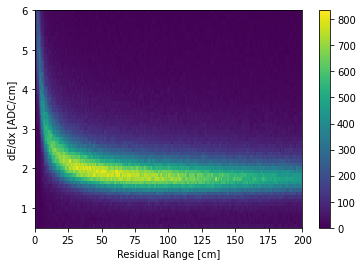

In [23]:
binx = np.linspace(0., 200., 201)
biny = np.linspace(0.5, 6, 61)

varx = plane2_stopcalo.rr
vary = plane2_stopcalo.dedx

_ = plt.hist2d(varx, vary, bins=[binx, biny])#, norm=colors.LogNorm())
plt.colorbar()
plt.xlabel("Residual Range [cm]")
plt.ylabel("dE/dx [ADC/cm]")


In [129]:
rrs = np.linspace(5., 200., 40)
# rrs = np.linspace(150, 155., 2)
rrhis = rrs[1:]
rrlos = rrs[:-1]
RRs = (rrhis + rrlos)/2.
bins = np.linspace(0, 6, 61)
bin_centers = (bins[1:] + bins[:-1]) / 2.

MPV_dedxs = []

langau_params = []
langau_param_errs = []

fit_scale = 1.

#pitches = np.linspace(0.3, 0.7, 5)
pitches = np.array([0.3, 0.4, 0.5, 0.7, 1])
pitch_los = pitches[:-1]
pitch_his = pitches[1:]
Ps = (pitch_los + pitch_his) / 2.

for i,(rrlo, rrhi) in enumerate(zip(rrlos, rrhis)):
    langau_params.append([])
    langau_param_errs.append([])
    MPV_dedxs.append([])
    for j,(plo, phi) in enumerate(zip(pitch_los, pitch_his)):
        #print(plo, phi)
        #if i > 5: break
        when = (plane2_stopcalo.pitch < phi) & (plane2_stopcalo.pitch > plo) &\
            (plane2_stopcalo.rr > rrlo) & (plane2_stopcalo.rr < rrhi)
        N,_ = np.histogram(plane2_stopcalo.dedx[when], bins=bins)
        
        # only fit near peak
        maxbin = np.argmax(N)
        when_fit = np.abs(np.array(range(len(bin_centers))) - maxbin) < 10 # within 10 bins

        p0 = [bin_centers[maxbin]*fit_scale, 0.1*fit_scale, 0.4*fit_scale, 40*np.max(N)]



        popt, perr = curve_fit(landau_gaus, (bin_centers * fit_scale)[when_fit], N[when_fit], p0=p0, maxfev=10_000, sigma=np.maximum(np.sqrt(N), 1)[when_fit])
        MPV_dedxs[i].append(popt[0] / fit_scale)
        langau_params[i].append(popt)
        langau_param_errs[i].append(perr)
    
MPV_dedxs = np.array(MPV_dedxs)

In [130]:
langau_params_unscaled = []
for i in range(len(RRs)):
    langau_params_unscaled.append([])
    for j in range(len(Ps)):
        langau_params_unscaled[i].append( np.hstack([langau_params[i][j][:3] / fit_scale, [langau_params[i][j][3]]]) )

In [131]:
mpv_err = np.array([[np.sqrt(np.diag(perr)[0]) for perr in perr_cols] for perr_cols in langau_param_errs])

<ipython-input-132-e8e88de1ff91>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(iplot)


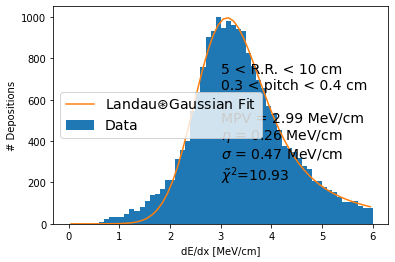

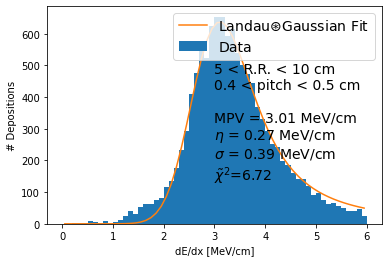

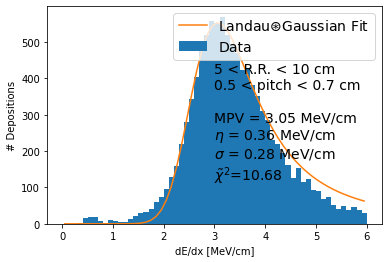

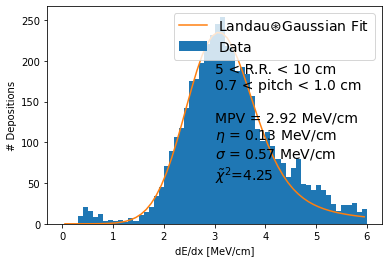

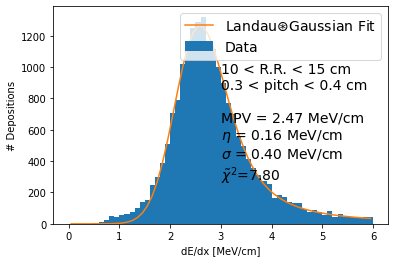

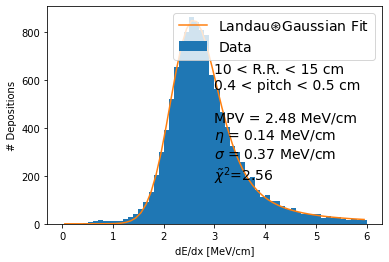

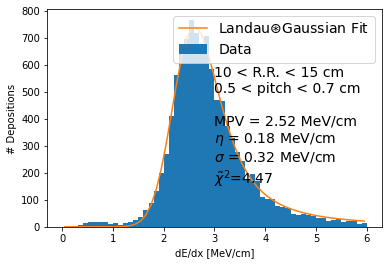

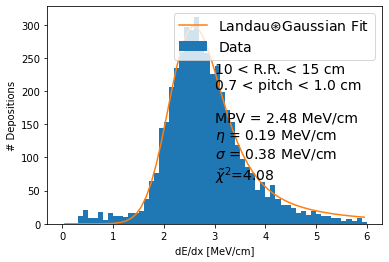

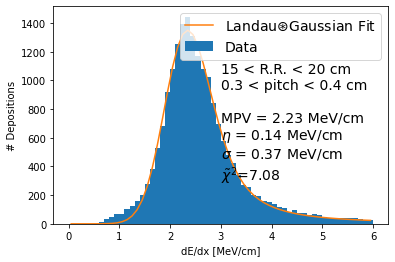

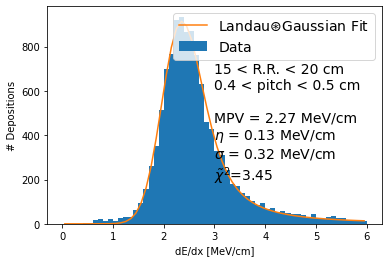

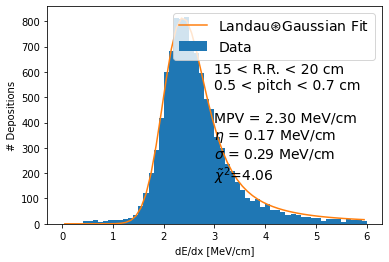

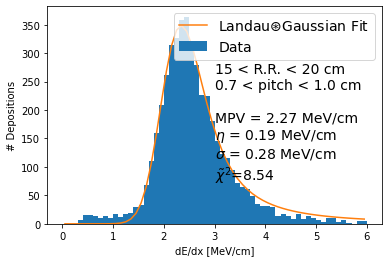

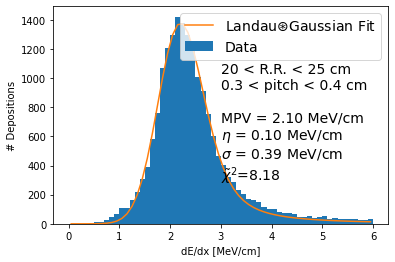

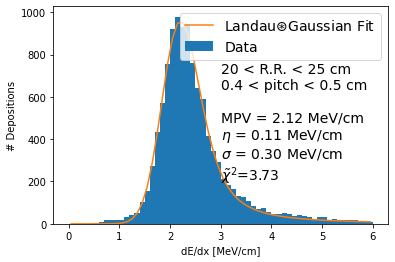

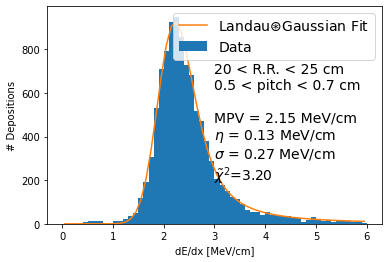

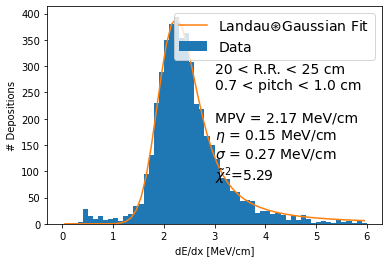

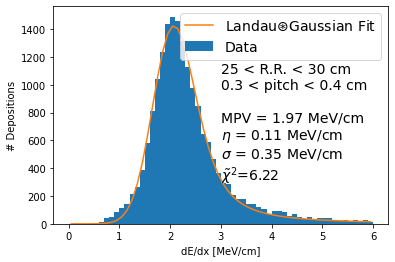

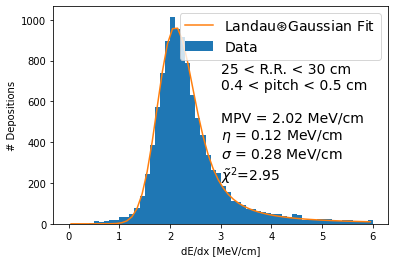

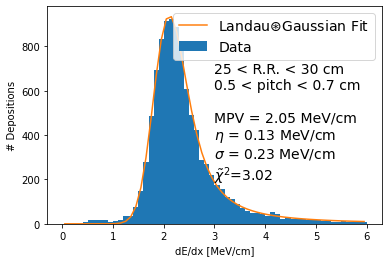

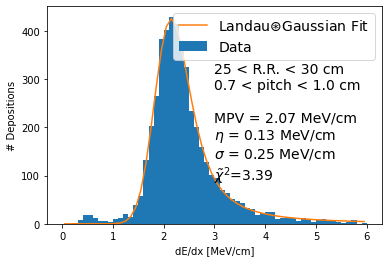

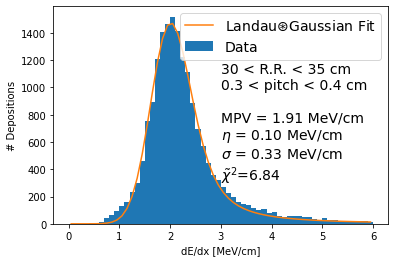

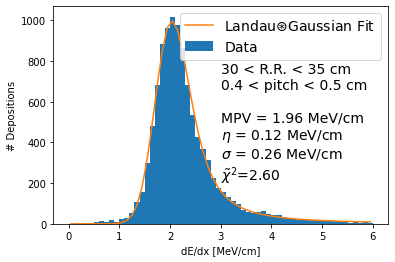

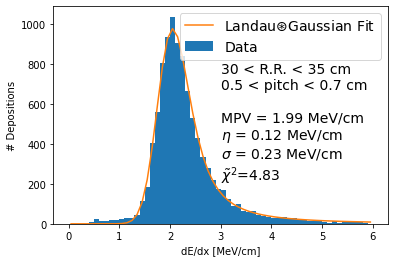

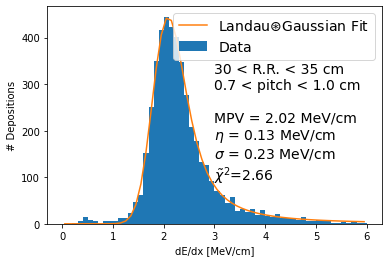

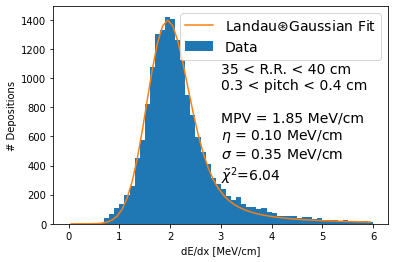

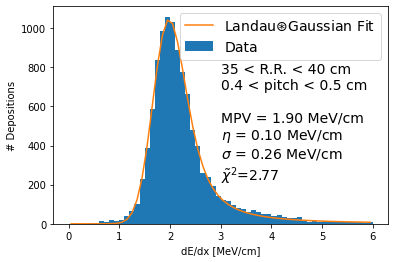

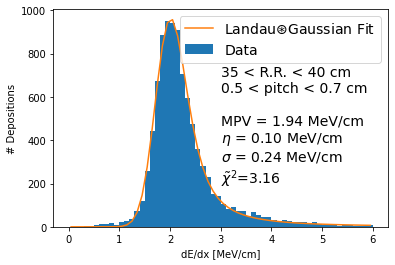

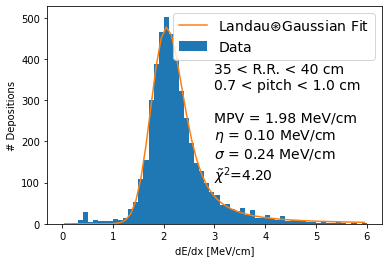

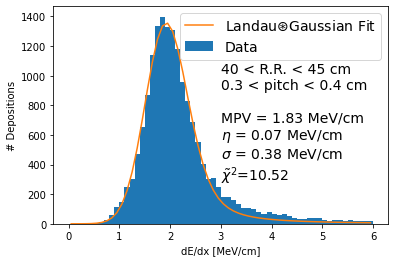

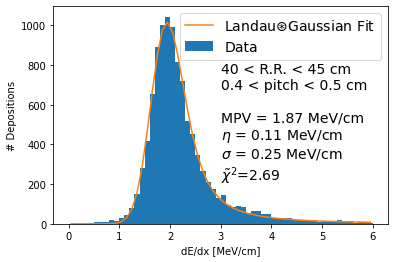

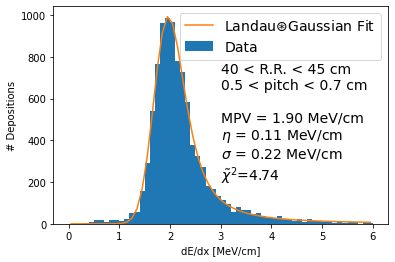

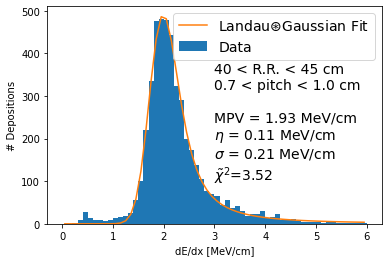

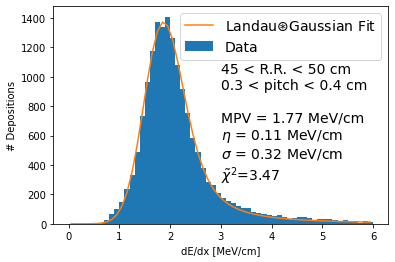

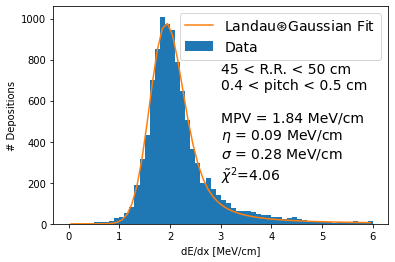

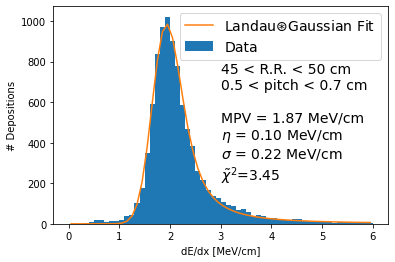

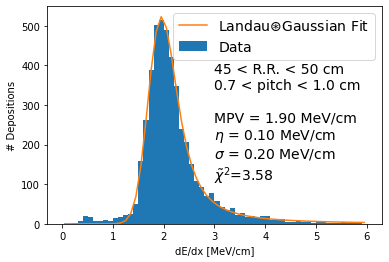

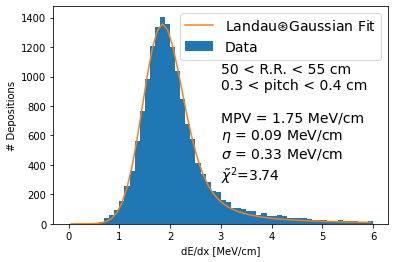

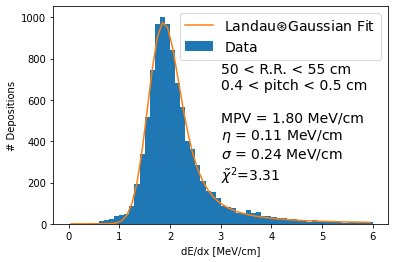

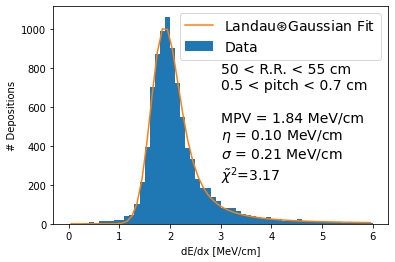

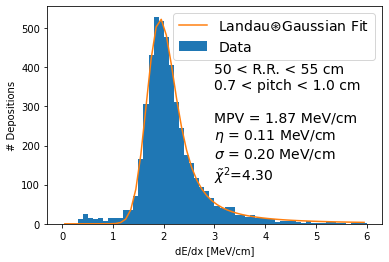

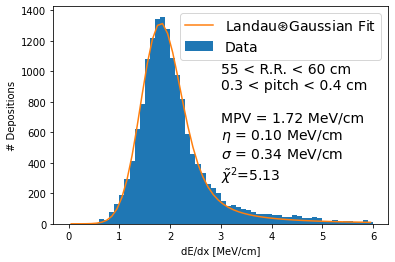

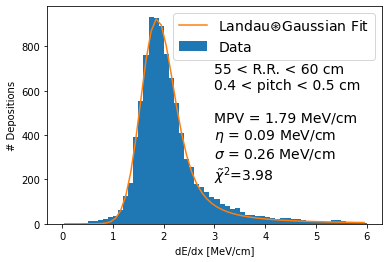

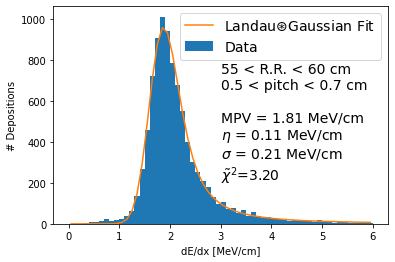

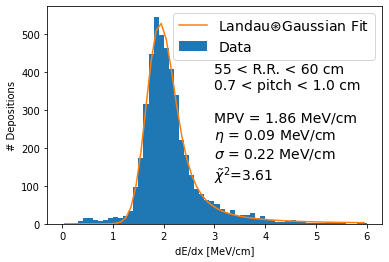

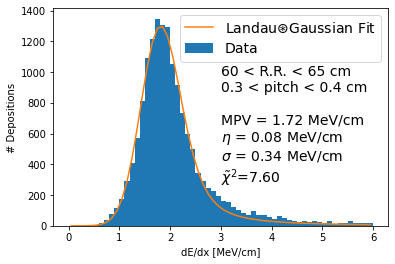

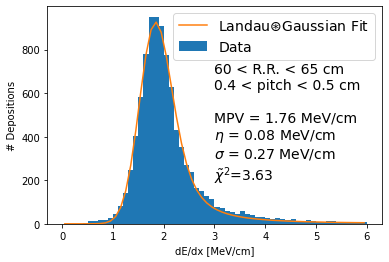

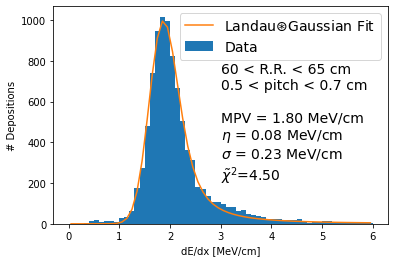

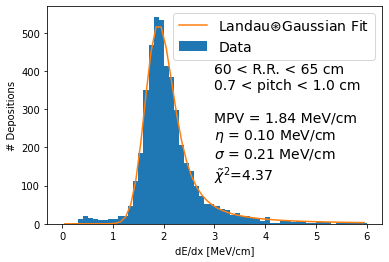

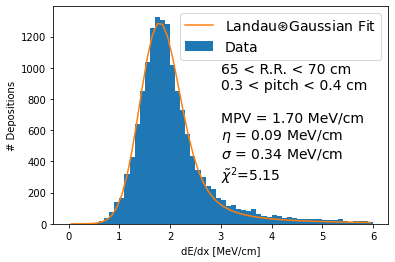

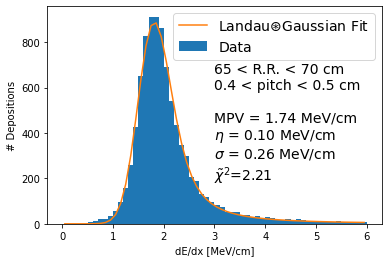

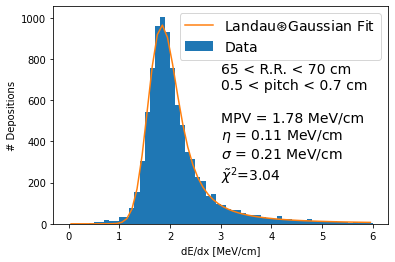

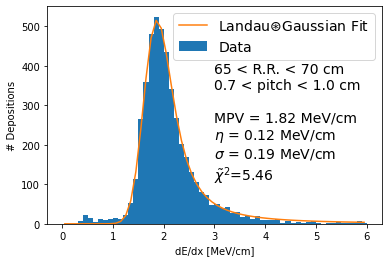

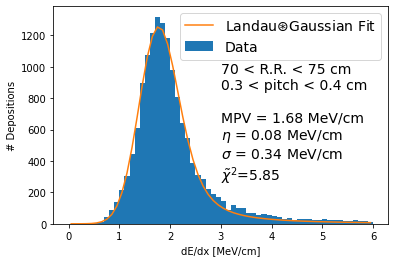

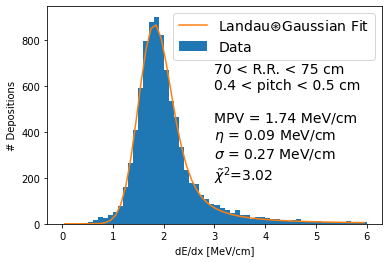

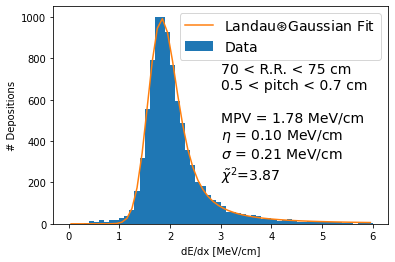

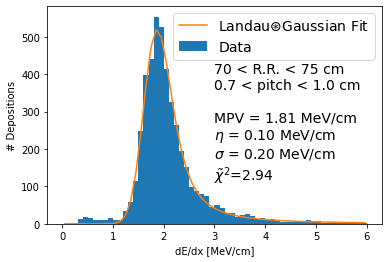

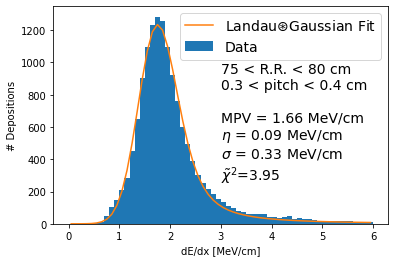

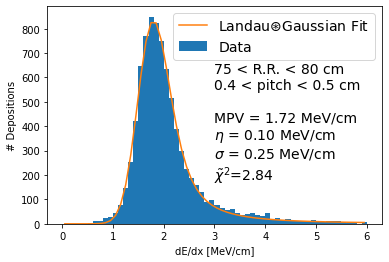

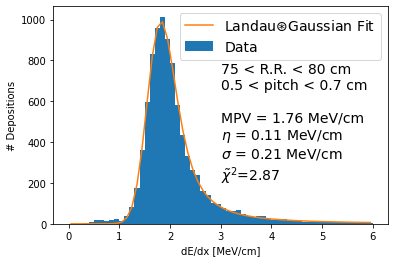

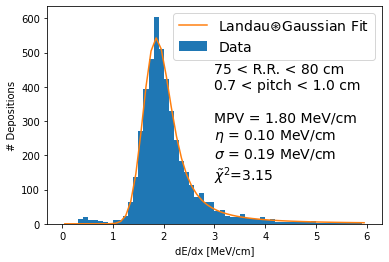

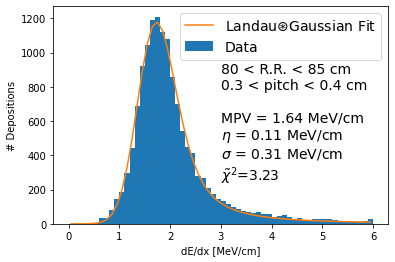

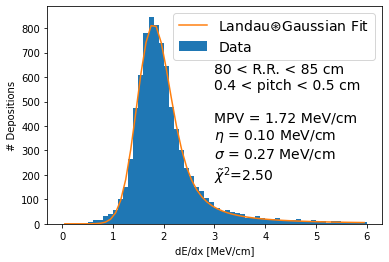

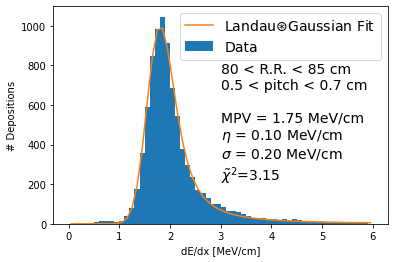

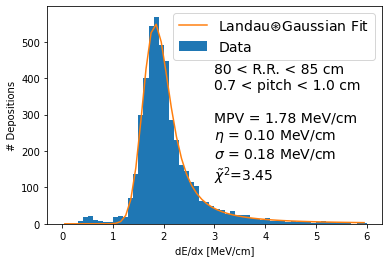

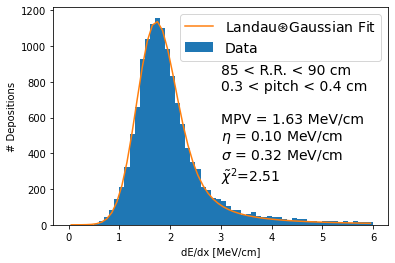

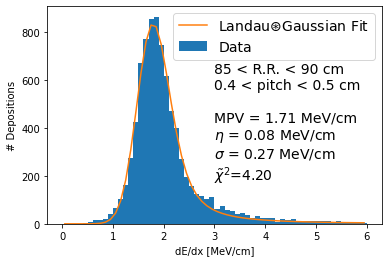

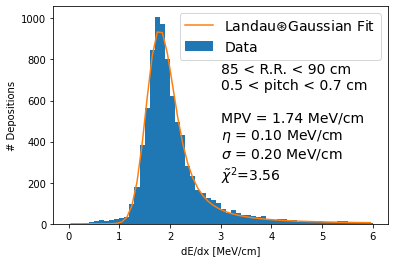

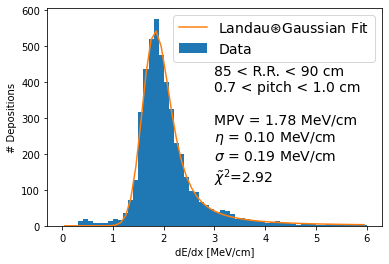

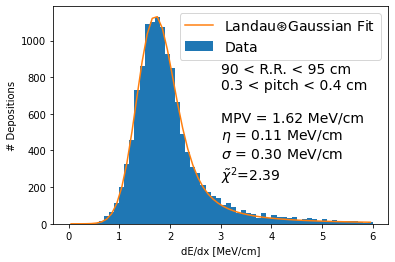

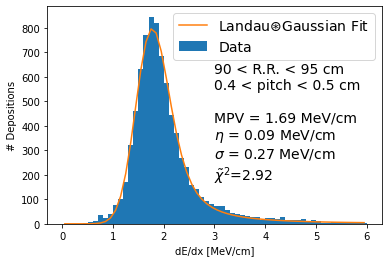

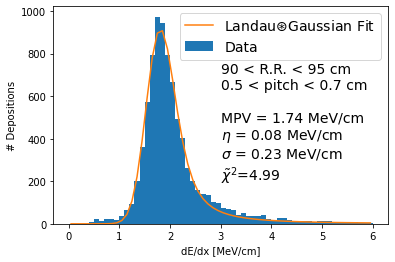

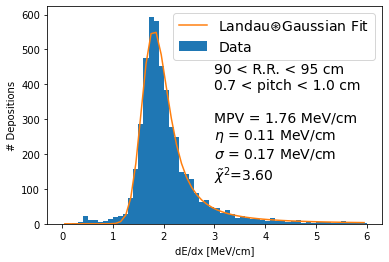

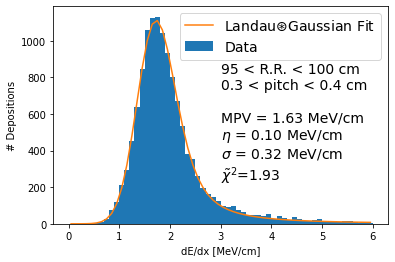

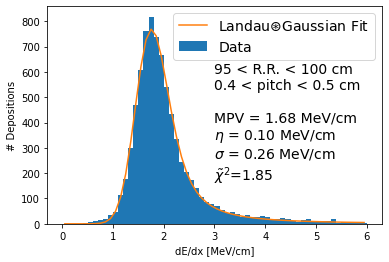

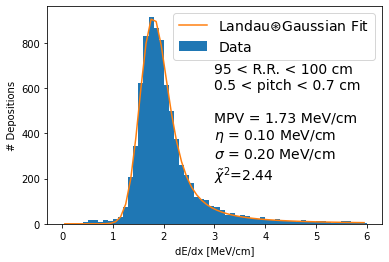

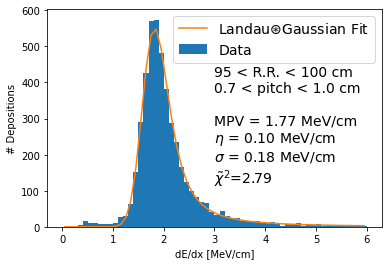

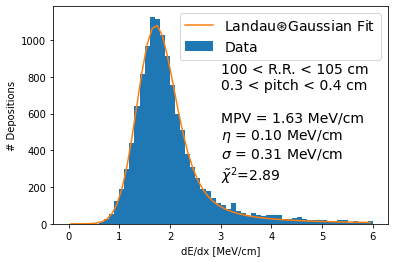

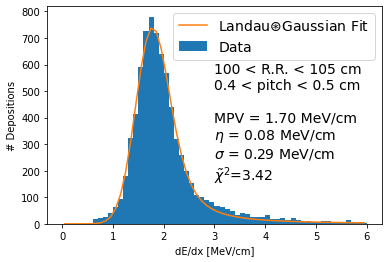

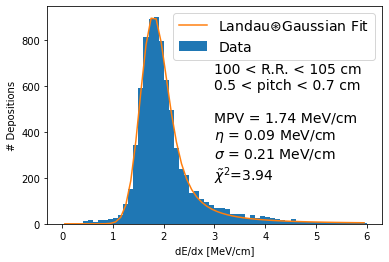

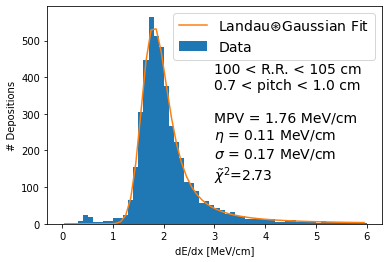

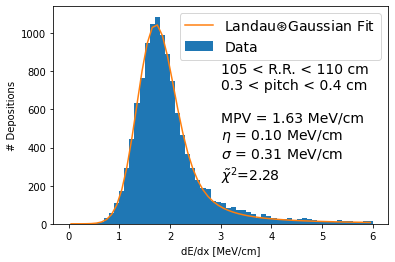

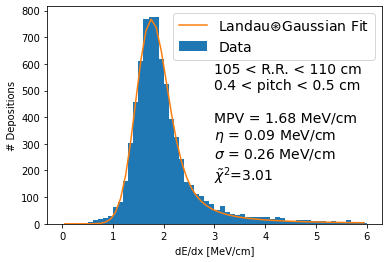

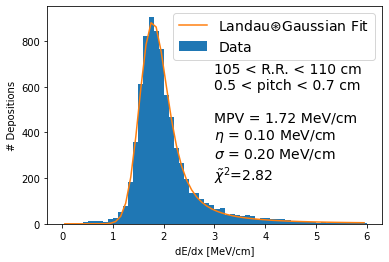

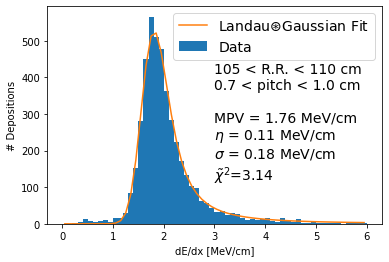

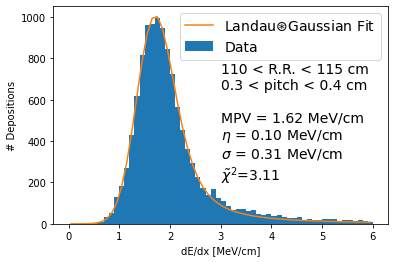

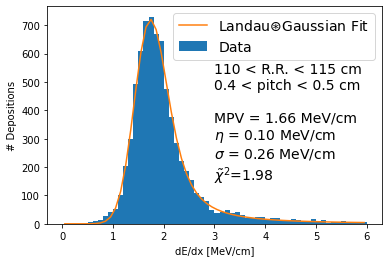

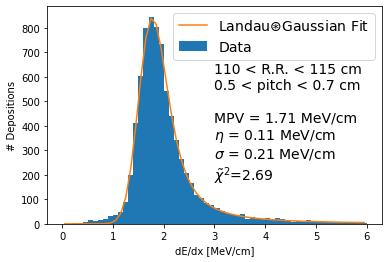

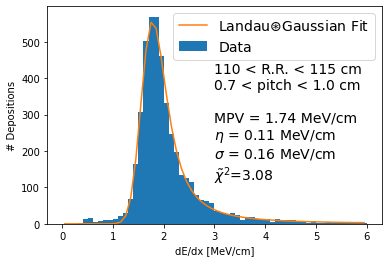

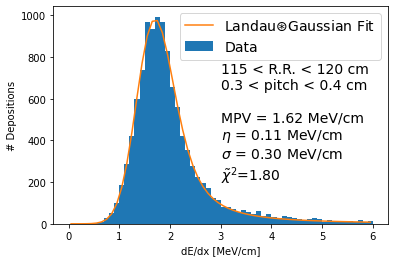

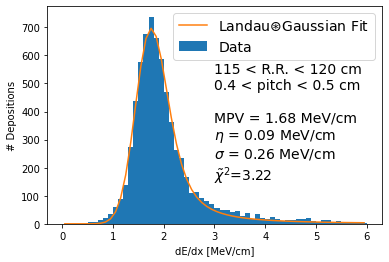

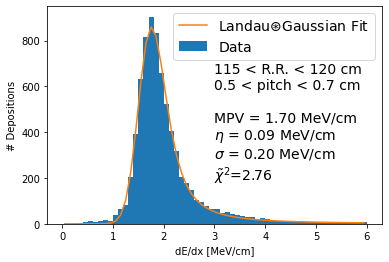

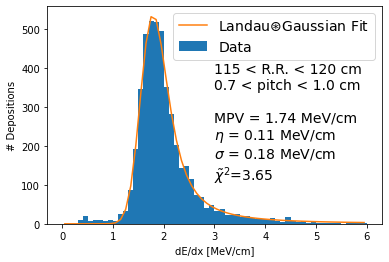

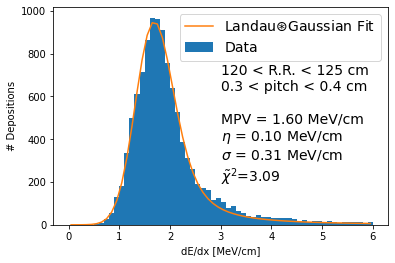

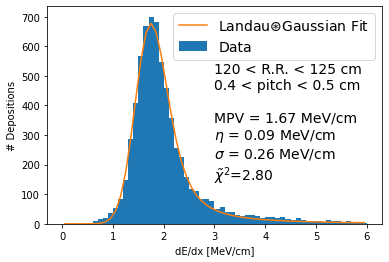

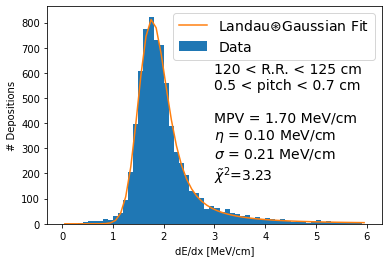

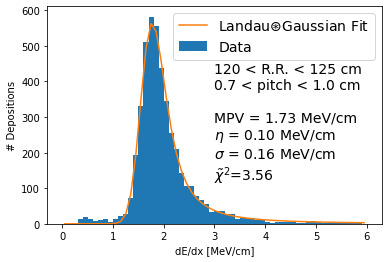

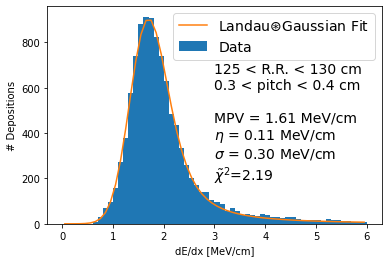

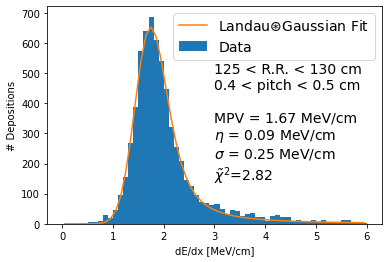

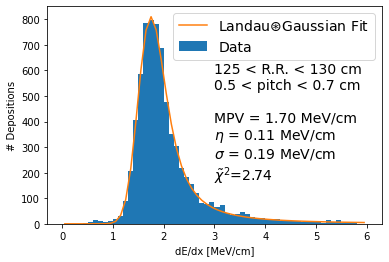

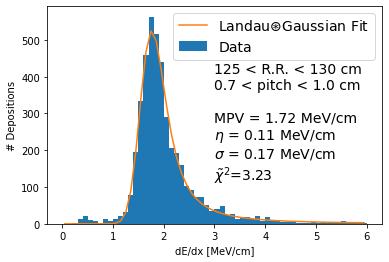

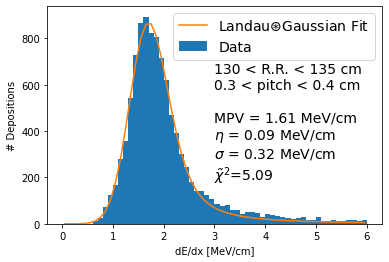

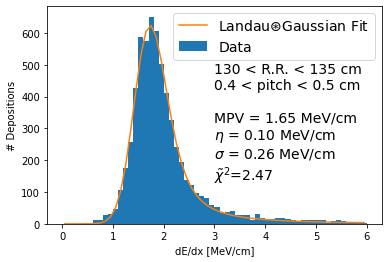

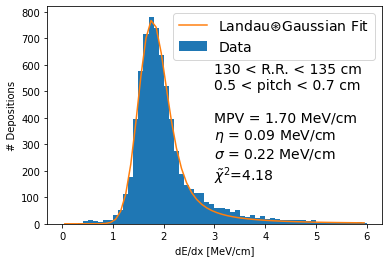

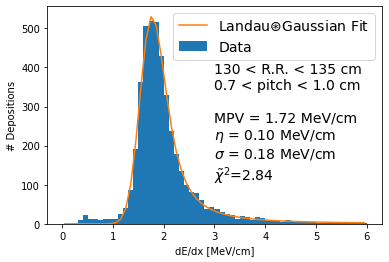

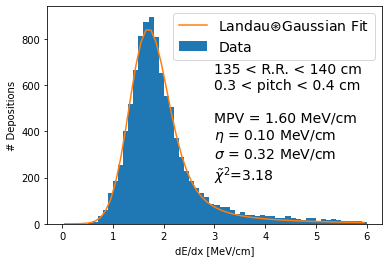

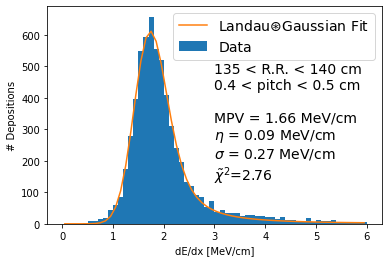

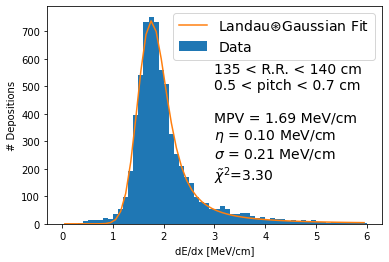

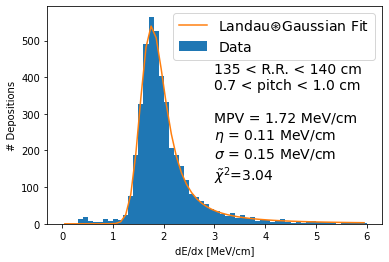

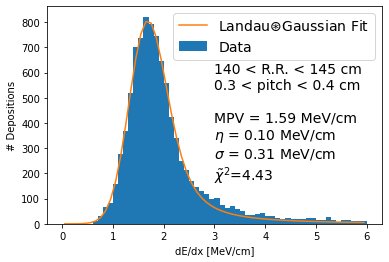

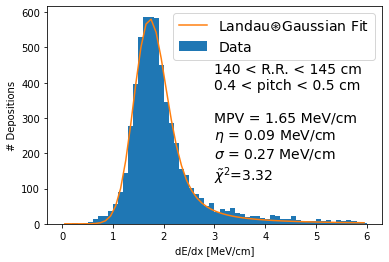

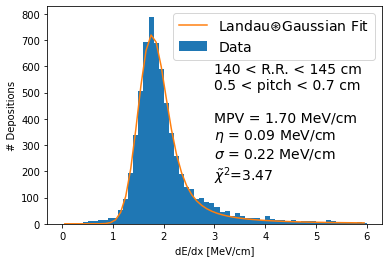

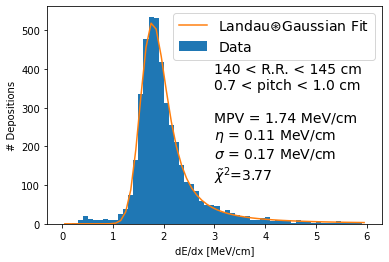

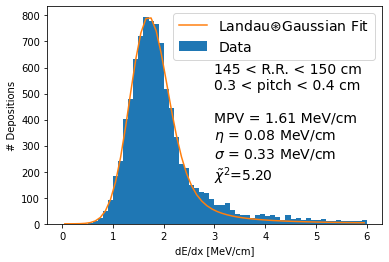

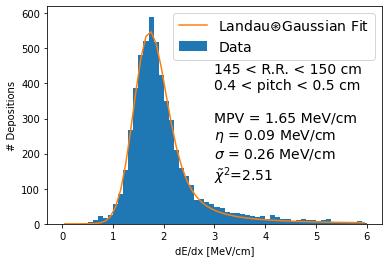

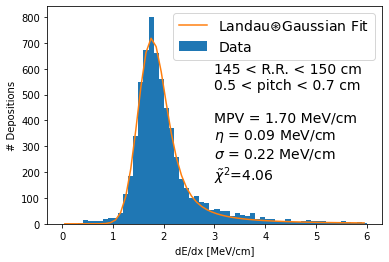

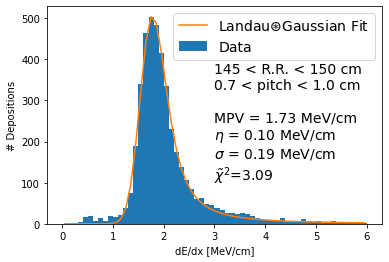

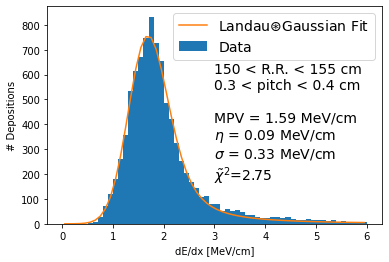

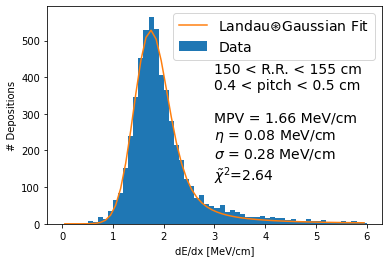

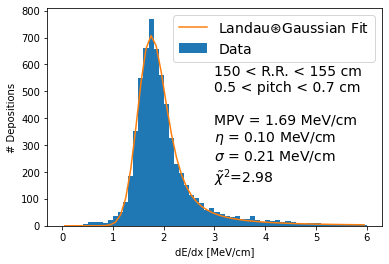

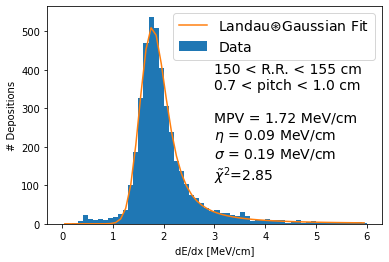

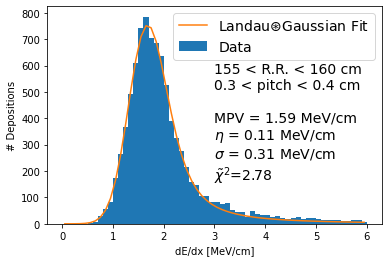

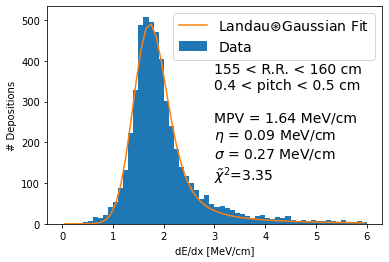

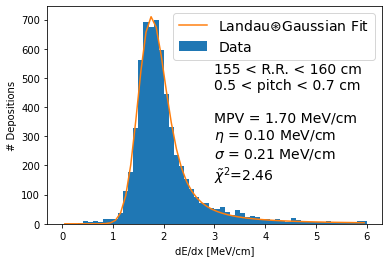

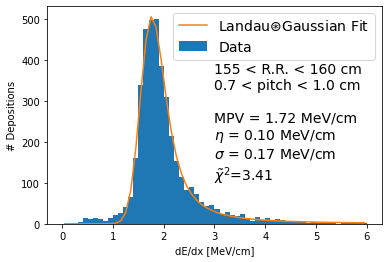

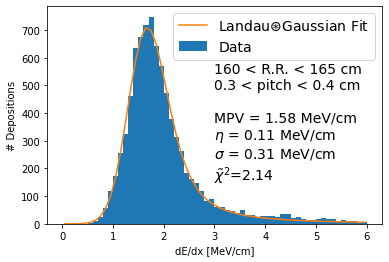

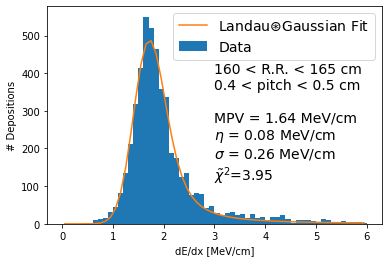

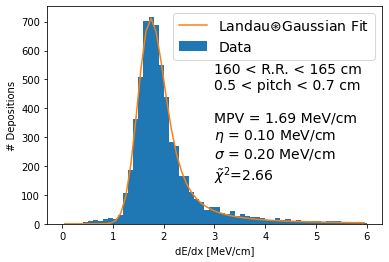

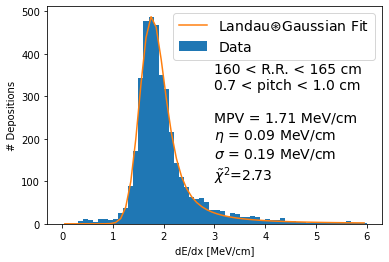

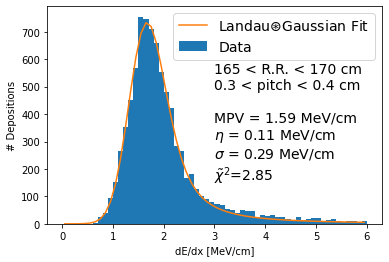

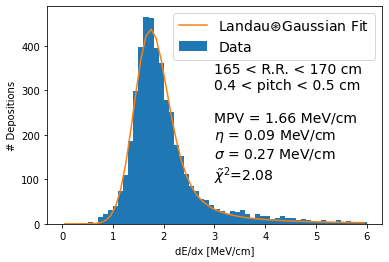

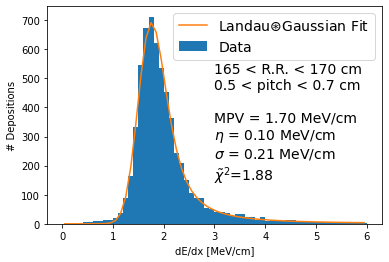

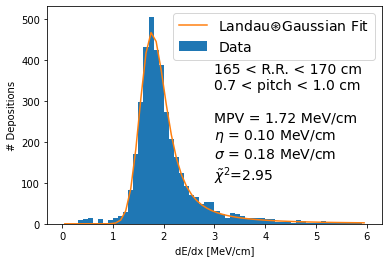

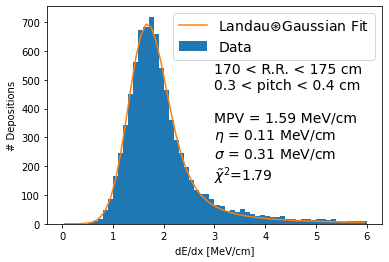

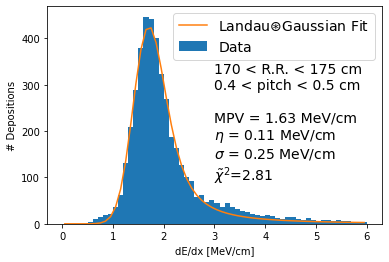

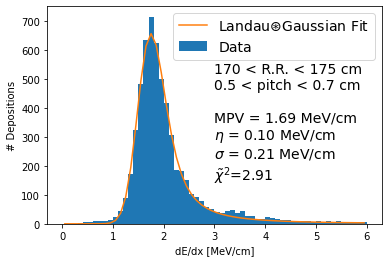

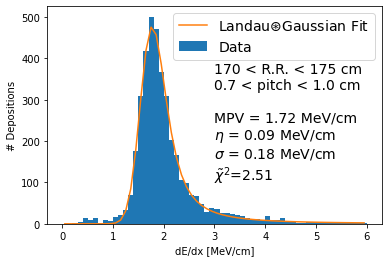

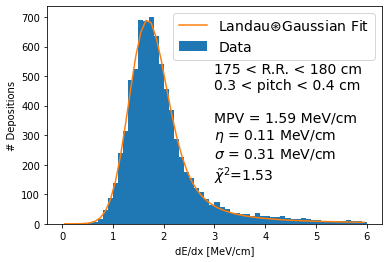

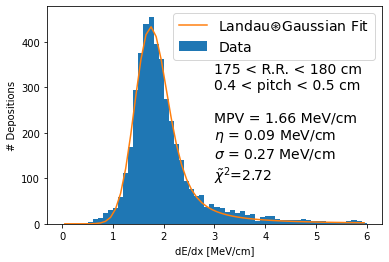

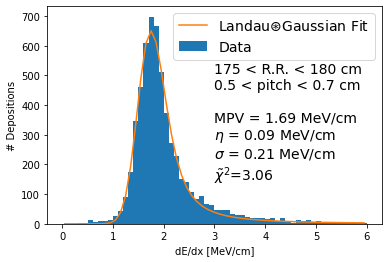

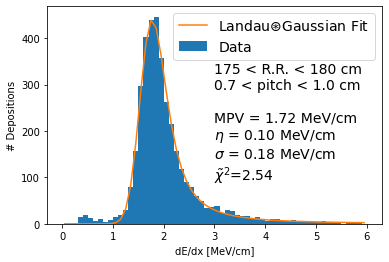

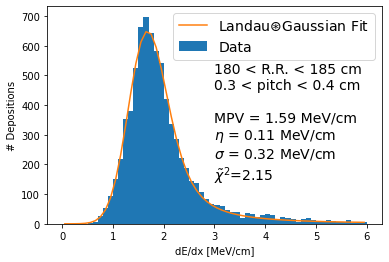

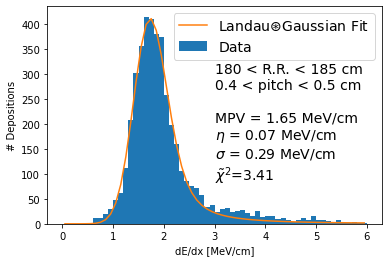

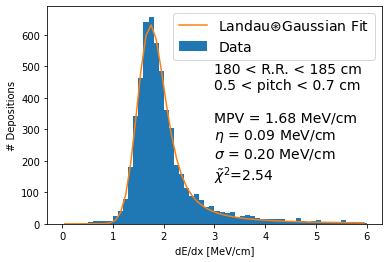

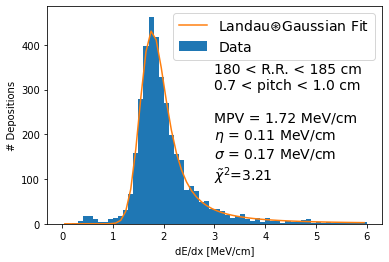

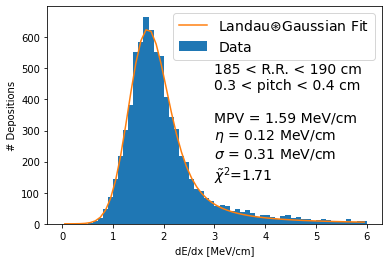

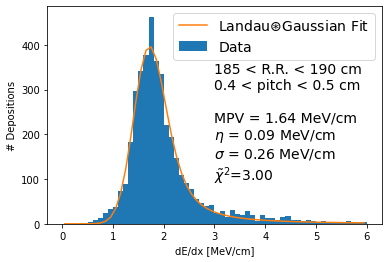

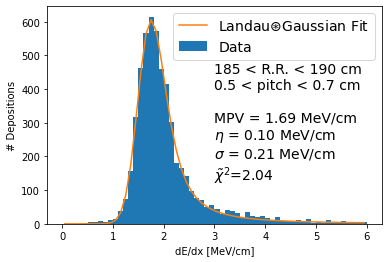

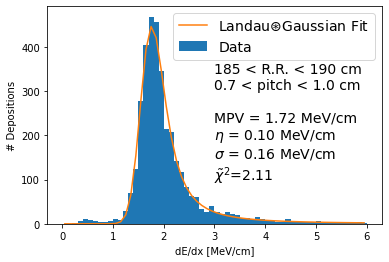

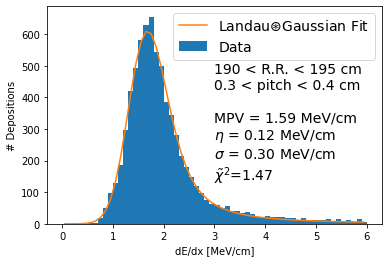

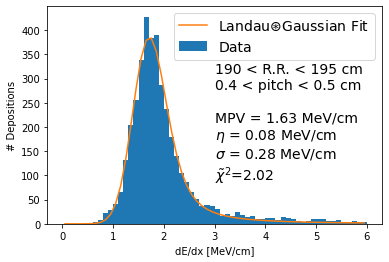

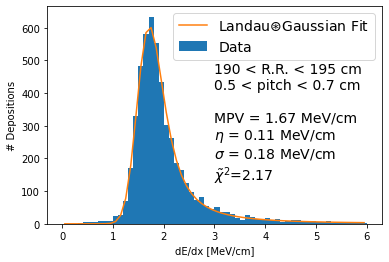

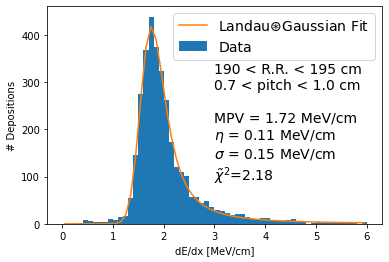

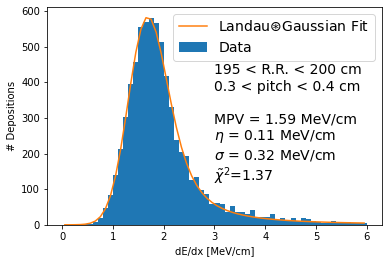

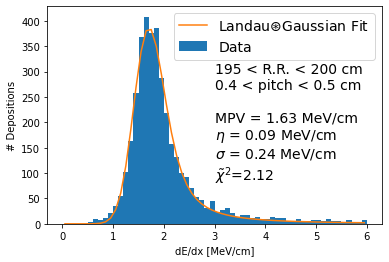

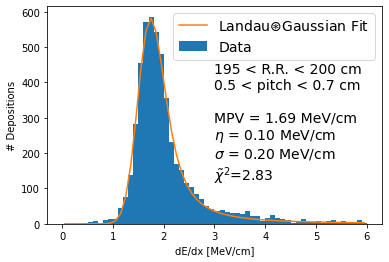

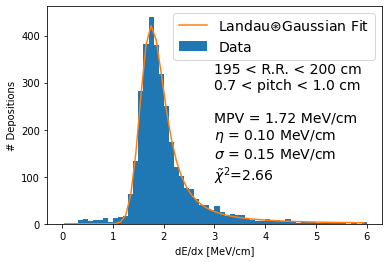

In [132]:
# Plot fits

iplot = i
for IND in range(len(RRs)):
    for JND in range(len(Ps)):
        plt.figure(iplot)
        iplot += 1
        when = (plane2_stopcalo.pitch < pitch_his[JND]) & (plane2_stopcalo.pitch > pitch_los[JND]) &\
                (plane2_stopcalo.rr > rrlos[IND]) & (plane2_stopcalo.rr < rrhis[IND])

        N,_,_ = plt.hist(plane2_stopcalo.dedx[when], bins=bins, label="Data")
        chi2 = langau_chi2(bin_centers, N, np.maximum(np.sqrt(N), 1), langau_params[IND][JND]) / (np.sum(N>0) -2)

        plt.plot(bin_centers, landau_gaus(bin_centers * fit_scale, *langau_params[IND][JND]), label="Landau$\circledast$Gaussian Fit")
        plt.legend(fontsize=14)
        plt.text(0.5, 0.2, "%.0f < R.R. < %.0f cm\n%.1f < pitch < %.1f cm\n\nMPV = %.2f MeV/cm\n$\eta$ = %.2f MeV/cm\n$\sigma$ = %.2f MeV/cm\n$\\tilde{\\chi}^2$=%.2f" % tuple([rrlos[IND], rrhis[IND], pitch_los[JND], pitch_his[JND]] + list(langau_params_unscaled[IND][JND][:3]) + [chi2]),
                fontsize=14, transform=plt.gca().transAxes)

        plt.xlabel("dE/dx [MeV/cm]")
        plt.ylabel("# Depositions")
        if dosave: plt.savefig(savedir + "dedx_langau_fit_RR%.0f_%.0f.png" % (rrlos[IND], rrhis[IND]))

In [150]:
RR2DEDXs = []
for i,(plo, phi) in enumerate(zip(pitch_los, pitch_his)):
    mean_pitch = np.mean(plane2_stopcalo.pitch[(plane2_stopcalo.pitch < phi) & (plane2_stopcalo.pitch > plo)])
    print(mean_pitch)
    #mean_pitch = (phi + plo) / 2.
    MPV_dEDX_points = Calc_MPV_DEDX(mean_pitch, KE_points)
    RR2DEDX = CubicSpline(RR_points, MPV_dEDX_points)
    RR2DEDXs.append(RR2DEDX)

0.3490106
0.44568387
0.58557963
0.8225626


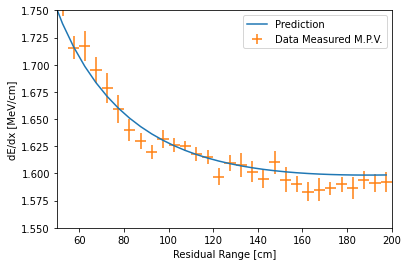

In [151]:
plt.plot(RRs, RR2DEDXs[0](RRs), label="Prediction")
plt.errorbar(RRs, MPV_dedxs[:,0], yerr=mpv_err[:,0], xerr=2.5, ls="none", label="Data Measured M.P.V.")
plt.legend()
plt.xlabel("Residual Range [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.xlim([50, 200])
plt.ylim([1.55, 1.75])

if dosave: plt.savefig(savedir + "dEdx_predictionVdata.png")

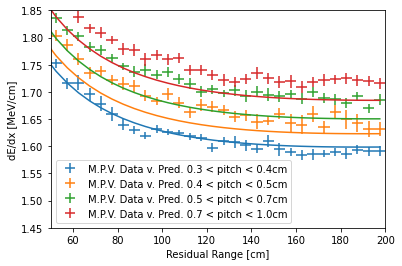

In [153]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,(plo, phi) in enumerate(zip(pitch_los, pitch_his)):
    plt.plot(RRs, RR2DEDXs[i](RRs), label=None, color=colors[i])
    plt.errorbar(RRs, MPV_dedxs[:,i], yerr=mpv_err[:,i], xerr=2.5, ls="none", color=colors[i],
                 label="M.P.V. Data v. Pred. %.1f < pitch < %.1fcm" % (plo, phi))
    plt.legend()
    plt.xlabel("Residual Range [cm]")
    plt.ylabel("dE/dx [MeV/cm]")
plt.xlim([50, 200])
plt.ylim([1.45, 1.85])

if dosave: plt.savefig(savedir + "dEdx_predictionVdata.png")

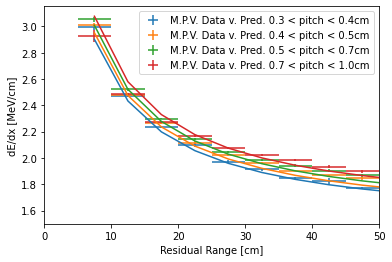

In [155]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,(plo, phi) in enumerate(zip(pitch_los, pitch_his)):
    plt.plot(RRs, RR2DEDXs[i](RRs), label=None, color=colors[i])
    plt.errorbar(RRs, MPV_dedxs[:,i], yerr=mpv_err[:,i], xerr=2.5, ls="none", color=colors[i],
                 label="M.P.V. Data v. Pred. %.1f < pitch < %.1fcm" % (plo, phi))
    plt.legend()
    plt.xlabel("Residual Range [cm]")
    plt.ylabel("dE/dx [MeV/cm]")
plt.xlim([0, 50.])
#plt.ylim([1.45, 1.85])

if dosave: plt.savefig(savedir + "dEdx_predictionVdata.png")

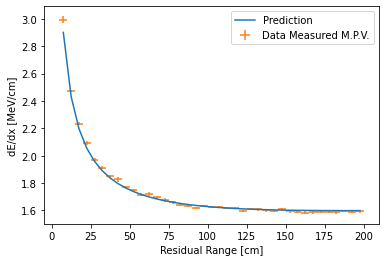

In [143]:
plt.plot(RRs, RR2DEDXs[0](RRs), label="Prediction")
plt.errorbar(RRs, MPV_dedxs[:,0], yerr=mpv_err[:,0], xerr=2.5, ls="none", label="Data Measured M.P.V.")
plt.legend()
plt.xlabel("Residual Range [cm]")
plt.ylabel("dE/dx [MeV/cm]")
#plt.yscale("log")
#plt.xscale("log")
if dosave: plt.savefig(savedir + "dEdx_predictionVdata.png")